In [7]:
import numpy as np
import normflowpy as nfp
import datasets
import torch
from matplotlib import pyplot as plt
from torch.distributions import MultivariateNormal
from tqdm.notebook import tqdm

In [8]:
dataset_type=datasets.DatasetType.MOONS
n_training_samples=50000
n_validation_samples=10000
n_flow_blocks=3
batch_size=32
n_epochs=50
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Working Device is set to:" + str(device))
training_data=datasets.get_dataset(dataset_type,n_training_samples)
training_dataset_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                                          shuffle=True, num_workers=0)

validation_data=datasets.get_dataset(dataset_type,n_validation_samples)
validation_dataset_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                                          shuffle=False, num_workers=0)

Current Working Device is set to:cuda


# Training functions

In [9]:
def _run_training_loop(in_training_dataset,in_flow_model,in_optimizer,in_device):
    in_flow_model.train()
    loss_sum=0
    n=len(in_training_dataset)
    for x in in_training_dataset:
            x = x.to(in_device)
            in_optimizer.zero_grad()
            loss = in_flow_model.nll_mean(x)
            loss.backward()
            in_optimizer.step()
            loss_sum+=loss.item()
    return loss_sum/n

def _run_validation_loop(in_validation_dataset,in_flow_model,in_device):
    in_flow_model.eval()
    loss_sum=0
    n=len(in_validation_dataset)
    with torch.no_grad():
        for x in in_validation_dataset: 
            x = x.to(in_device)
            loss = in_flow_model.nll_mean(x)
            loss_sum+=loss.item()
    return loss_sum/n
        
def run_training(in_n_epoch,in_training_dataset,in_validation_dataset,in_flow_model,in_optimizer,in_device):
    print("Starting Training Loop")
    for epoch in tqdm(range(in_n_epoch)):
        loss_training=_run_training_loop(in_training_dataset,in_flow_model,in_optimizer,in_device)
        loss_validation=_run_validation_loop(in_validation_dataset,in_flow_model,in_device)
        print(f"End Epoch with training loss:{loss_training} and validtion loss:{loss_validation}")
    
def generate_probability_map(n_points,x_min,x_max,y_min,y_max,in_flow_model,in_device):
    results=[]
    for x in torch.linspace(x_min,x_max,n_points):
        _results_y=[]
        for y in torch.linspace(y_min,y_max,n_points):
            d=torch.stack([x,y]).reshape([1,-1]).to(in_device)
            _results_y.append(in_flow_model.nll(d).item())
        results.append(_results_y)
    return np.exp(-np.asarray(results)).T

# Create Normalzing Flow Model

In [10]:
dim=training_data.dim() # get data dim
base_distribution=MultivariateNormal(torch.zeros(dim, device=device),torch.eye(dim, device=device)) # generate a class for base distribution
flows = []
for i in range(n_flow_blocks):
    flows.append(
            nfp.flows.ActNorm(dim=dim))
    flows.append(
            nfp.flows.InvertibleFullyConnected(dim=dim))
    flows.append(
                nfp.flows.AffineCoupling(x_shape=[dim], parity=i % 2,net_class=nfp.base_nets.generate_mlp_class(),nh=32))
flow=nfp.NormalizingFlowModel(base_distribution, flows).to(device)
optimizer=torch.optim.Adam(flow.parameters(),lr=1e-4)
run_training(n_epochs,training_dataset_loader,validation_dataset_loader,flow,optimizer,device)

Starting Training Loop


  0%|          | 0/50 [00:00<?, ?it/s]

End Epoch with training loss:0.8698726548495692 and validtion loss:0.6824712966577694
End Epoch with training loss:0.6250847763002338 and validtion loss:0.5850818284784263
End Epoch with training loss:0.5701285785043843 and validtion loss:0.5511062715571529
End Epoch with training loss:0.5451928082560394 and validtion loss:0.5311594713991061
End Epoch with training loss:0.5268900481386972 and validtion loss:0.5217457414625551
End Epoch with training loss:0.5110959737101046 and validtion loss:0.5039895567269371
End Epoch with training loss:0.49380674922001033 and validtion loss:0.4810016613227491
End Epoch with training loss:0.4781295990074436 and validtion loss:0.4647568029146225
End Epoch with training loss:0.4640751095990378 and validtion loss:0.4589483047636172
End Epoch with training loss:0.44980976118998733 and validtion loss:0.4501184353622766
End Epoch with training loss:0.44023092742234715 and validtion loss:0.4316554964540866
End Epoch with training loss:0.4335819871396646 and

In [11]:
x_min=-1.4
x_max=2.1
y_min=-1
y_max=1.5
res=generate_probability_map(200,x_min,x_max,y_min,y_max,flow,device)

/tmp/ipykernel_2108275/2954670075.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(xx,yy,res)


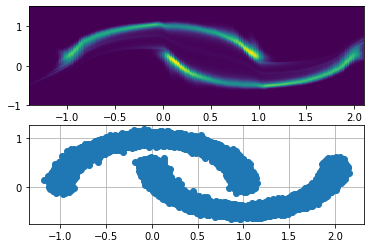

In [12]:
fig, (ax0,ax1) = plt.subplots(2)
x=np.linspace(x_min,x_max,200)
y=np.linspace(y_min,y_max,200)


xx,yy=np.meshgrid(x,y)
im = ax0.pcolormesh(xx,yy,res)

ax1.plot(training_data[:,0],training_data[:,1],"o")
ax1.grid()
plt.show()